# Config

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from matplotlib import pyplot
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pmd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error


# Main Objective

Main objective of this task is to find the best method to predict future values of milk collection based on given data.

# Loading data

In [2]:
data = {
    
}

In [3]:
data["delivery"] = pd.read_excel("Delivery_data.xlsx")

In [4]:
data["delivery"].head(5)

,Farm ID,Rok,Tydzień,Start tygodnia,Ilość,y,y_raw
0,1311,2022,1,2022-01-03,8683.23,10149.08,10149.08
1,1270,2022,1,2022-01-03,4841.73,4225.18,4225.18
2,1317,2022,1,2022-01-03,12363.43,10861.82,10861.82
3,1271,2022,1,2022-01-03,3115.41,3642.37,3642.37
4,1132,2022,1,2022-01-03,925.49,1076.46,1076.46


## Translation of column names

In [5]:
data["delivery"] = data["delivery"].rename(columns= {"Tydzień" : "Week", "Start tygodnia" : "First day of the week", "Ilość":"Quantity", "Rok":"Year"})

## Brief description of data

In [6]:
data["delivery"].head(1)

,Farm ID,Year,Week,First day of the week,Quantity,y,y_raw
0,1311,2022,1,2022-01-03,8683.23,10149.08,10149.08


In [7]:
# Farm ID is an unique indetifier to determine overall quantity of milk delivered by spiecified supplier
data["delivery"]["Farm ID"].nunique()

320

In [8]:
# Year is the year of milk delivery - between 2022 and 2024
display(data["delivery"]["Year"].nunique())
display(data["delivery"]["Year"].unique())

3

array([2022, 2023, 2024])

In [9]:
# week is the week of milk delivery - between 1 and 52
display(data["delivery"]["Week"].nunique())
display(data["delivery"]["Week"].unique())

52

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52])

In [10]:
# first day of the week is dtype datetime64[ns] object. The first day of the week delivery - between 2022-01-03 00:00:00 and 2024-12-23 00:00:00
display(data["delivery"]["First day of the week"].nunique())
display(data["delivery"]["First day of the week"].unique())

156

<DatetimeArray>
['2022-01-03 00:00:00', '2022-01-10 00:00:00', '2022-01-17 00:00:00',
 '2022-01-24 00:00:00', '2022-01-31 00:00:00', '2022-02-07 00:00:00',
 '2022-02-14 00:00:00', '2022-02-21 00:00:00', '2022-02-28 00:00:00',
 '2022-03-07 00:00:00',
 ...
 '2024-10-21 00:00:00', '2024-10-28 00:00:00', '2024-11-04 00:00:00',
 '2024-11-11 00:00:00', '2024-11-18 00:00:00', '2024-11-25 00:00:00',
 '2024-12-02 00:00:00', '2024-12-09 00:00:00', '2024-12-16 00:00:00',
 '2024-12-23 00:00:00']
Length: 156, dtype: datetime64[ns]

In [11]:
# Quantity is the "raw" data from milk collection point
display(data["delivery"]["Quantity"].mean())

2297.9326886915383

In [12]:
# Quantity is the data that is treated as an only daily collection cycle

display(data["delivery"]["y_raw"].mean())

2298.5747168373996

In [13]:
# Quantity is the data that is cleared from outliers and is treated as an only daily collection cycle
display(data["delivery"]["y"].mean())

2299.1915784936755

# Data exploration

In [14]:
data["delivery"].describe()

,Farm ID,Year,Week,First day of the week,Quantity,y,y_raw
count,49883.000000,49883.000000,49883.000000,49883,49883.000000,49883.000000,49883.000000
mean,1160.493836,2023.000742,26.514303,2023-06-29 20:52:58.028587008,2297.932689,2299.191578,2298.574717
min,1001.000000,2022.000000,1.000000,2022-01-03 00:00:00,84.740000,73.320000,73.320000
25%,1080.000000,2022.000000,14.000000,2022-10-03 00:00:00,695.360000,713.910000,713.495000
50%,1160.000000,2023.000000,27.000000,2023-07-03 00:00:00,1364.360000,1390.190000,1389.640000
75%,1241.000000,2024.000000,40.000000,2024-04-01 00:00:00,2567.435000,2572.530000,2570.880000
max,1320.000000,2024.000000,52.000000,2024-12-23 00:00:00,52352.600000,52241.040000,52241.040000
std,92.401104,0.816353,15.004375,NaN,3394.440341,3367.655556,3368.607343


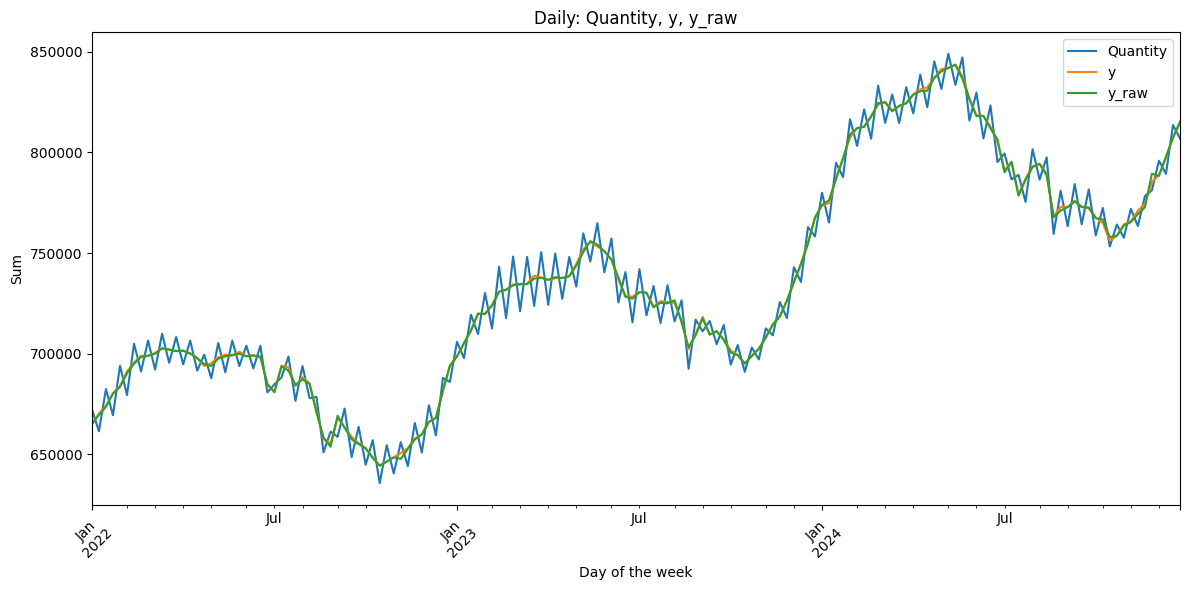

In [15]:
data["daily_sum"] = data["delivery"].groupby("First day of the week")[["Quantity", "y", "y_raw"]].sum()
data["daily_sum"].plot(kind="line", figsize=(12,6), title="Daily: Quantity, y, y_raw")
plt.xlabel("Day of the week")
plt.ylabel("Sum")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

As seen on plot above, the "quantity" behaves the worst because of spikes. Let's get rid of it

In [16]:
data["delivery"] = data["delivery"].drop(columns={"Quantity"})

In [17]:
data["delivery"].head(1)

,Farm ID,Year,Week,First day of the week,y,y_raw
0,1311,2022,1,2022-01-03,10149.08,10149.08


Let's now compare the y vs y_raw

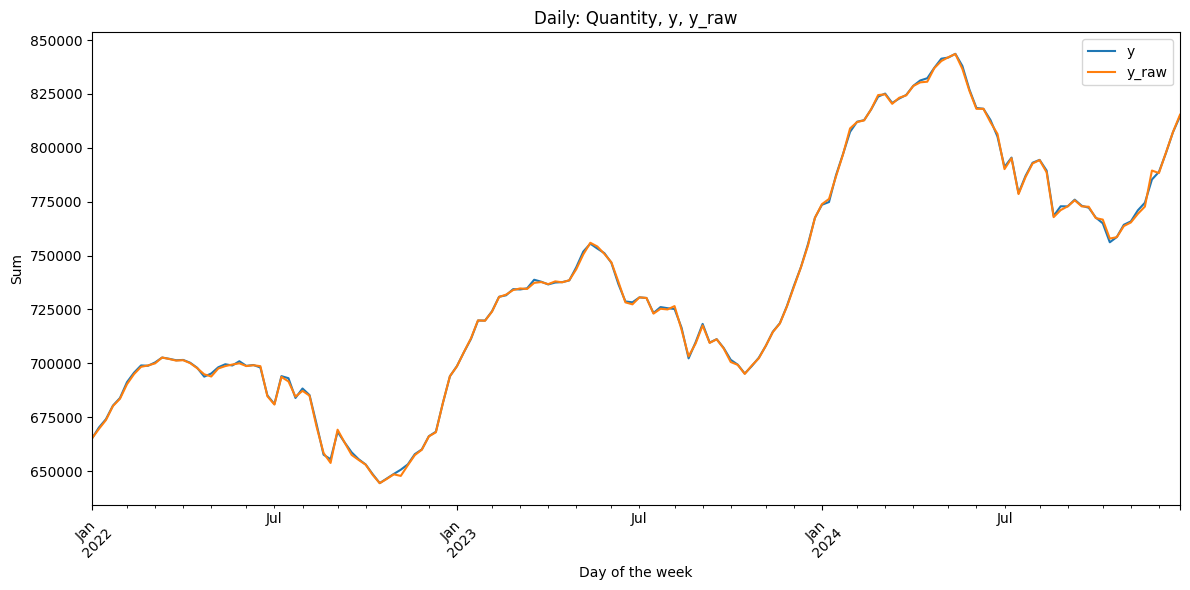

In [18]:
data["daily_sum"] = data["delivery"].groupby("First day of the week")[["y", "y_raw"]].sum()
data["daily_sum"].plot(kind="line", figsize=(12,6), title="Daily: Quantity, y, y_raw")
plt.xlabel("Day of the week")
plt.ylabel("Sum")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
# From my personal point of view, the "y" value seems to be better at smoothness. Let's drop y_raw

In [20]:
data["delivery"] = data["delivery"].drop(columns={"y_raw"})

In [21]:
data["delivery"].head(1)

,Farm ID,Year,Week,First day of the week,y
0,1311,2022,1,2022-01-03,10149.08


# Time series decomposition

In [22]:
data["daily_sum"].head()

,y,y_raw
First day of the week,,
2022-01-03,665032.23,665096.87
2022-01-10,670191.95,669532.12
2022-01-17,674053.09,673657.35
2022-01-24,680375.89,680165.20
2022-01-31,683891.50,683530.08


In [23]:
decompose_add.plot()
pyplot.show()

NameError: name 'decompose_add' is not defined

In [ ]:
decompose_mult = seasonal_decompose(data["daily_sum"]["y_raw"], model='multiplicative')
decompose_add = seasonal_decompose(data["daily_sum"]["y_raw"], model='additive')

In [ ]:
decompose_add.plot()
pyplot.show()

In [ ]:
decompose_mult.plot()
pyplot.show()

# Time series forecasting

In [ ]:
data["forecast"] = data["delivery"][['First day of the week', 'y']]

In [ ]:
data["forecast"] = data["forecast"].groupby("First day of the week").sum()

In [ ]:
data["forecast"].head()

In [ ]:
data["forecast"].plot()

## Prophet Model

In [ ]:
data["model_prophet"] = data["forecast"]

In [ ]:
data["model_prophet"].reset_index(inplace=True)

In [ ]:
data["model_prophet"].columns = ["ds", "y"]

In [ ]:
data["model_prophet"].head()

In [ ]:
model_prophet = Prophet()
model_prophet.fit(data["model_prophet"])
data["forecast_prophet"] = model_prophet.predict()

In [ ]:
data["model_prophet"]["yhat"] = data["forecast_prophet"]["yhat"]

In [ ]:
data["model_prophet"].plot(x = 'ds')

In [ ]:
# Okay, for this course result seems fair enough

### Prophet Model Forecast

In [ ]:
data["model_prophet"].drop('yhat',axis = 1)

In [ ]:
model_prophet = Prophet()
model_prophet.fit(data["model_prophet"])
data["forecast_prophet"] = model_prophet.make_future_dataframe(periods = 52, freq="ME")
data["forecast_prophet"] = model_prophet.predict()

In [ ]:
data["forecast_prophet"].head()

In [ ]:
data["model_prophet"]["yhat"] = data["forecast_prophet"]["yhat"]
data["model_prophet"]["yhat_lower"] = data["forecast_prophet"]["yhat_lower"]
data["model_prophet"]["yhat_upper"] = data["forecast_prophet"]["yhat_upper"]
data["model_prophet"]["trend"] = data["forecast_prophet"]["trend"]

In [ ]:
data["model_prophet"].plot(x='ds')

In [ ]:
# For now seems good enough

## ARIMA Model

### Testing for stationarity

In [ ]:
del data["forecast"]

In [ ]:
data["forecast"] = data["delivery"][['First day of the week', 'y']]
data["forecast"] = data["forecast"].groupby("First day of the week").sum()
data["model_ARIMA"] = data["forecast"]
data["model_ARIMA"].reset_index(inplace=True)
data["model_ARIMA"].columns = ["ds", "y"]

In [ ]:
adf_test = adfuller(data["model_ARIMA"]["y"])
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_acf(data["model_ARIMA"]["y"].dropna(), ax=ax, lags=40)
ax.set_title("ACF")
plt.tight_layout()
plt.show()

In [ ]:
## p-value > 0.05, so this indicates non-stationarity.

### Differencing data

In [ ]:
data["model_ARIMA"]["y_diff1"] = data["model_ARIMA"]["y"].diff(periods=1)
data["model_ARIMA"]["y_diff2"] = data["model_ARIMA"]["y"].diff(periods=2)
data["model_ARIMA"]["y_diff3"] = data["model_ARIMA"]["y"].diff(periods=3)

In [ ]:
adf_test = adfuller(data["model_ARIMA"]["y_diff1"].dropna())
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

In [ ]:
adf_test = adfuller(data["model_ARIMA"]["y_diff2"].dropna())
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

In [ ]:
adf_test = adfuller(data["model_ARIMA"]["y_diff3"].dropna())
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

In [ ]:
# hmm, p-value is barely below threshold.

In [ ]:
data["model_ARIMA"].plot(x="ds", y="y_diff3")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_acf(data["model_ARIMA"]["y_diff3"].dropna(), ax=ax, lags=40)
ax.set_title("ACF")
plt.tight_layout()
plt.show()


In [ ]:
# ACF looks like expected. Despite p_value lower than 0.05, data is still non-stationary. Let's try different approach.

In [ ]:
data["forecast"] = data["forecast"].drop(columns=["y_diff1", "y_diff2", "y_diff3"],axis=1)

### Log approach

In [ ]:
data["model_ARIMA"] = data["forecast"]

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(20, 15))

ax[0].plot(data["model_ARIMA"]["ds"], data["model_ARIMA"]["y"], label="Original series")
ax[1].plot(data["model_ARIMA"]["ds"], np.log(data["model_ARIMA"]["y"]), label="After log transform")
data["model_ARIMA"]["transformed"] = np.log(data["model_ARIMA"]["y"]).diff(periods = 12)
data["model_ARIMA"].dropna(inplace=True)
ax[2].plot(data["model_ARIMA"]["ds"], data["model_ARIMA"]["transformed"], label="After differencing");

In [ ]:
adf_test = adfuller(data["model_ARIMA"]["transformed"].dropna())
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_acf(data["model_ARIMA"]["transformed"].dropna(), ax=ax, lags=40)
ax.set_title("ACF")
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_pacf(data["model_ARIMA"]["transformed"].dropna(), ax=ax, lags=40)
ax.set_title("PACF")
plt.tight_layout()
plt.show()

In [ ]:
## As we can see, it's hard to prepare this data for ARIMA modelling. Let's try SARIMA.

## SARIMA Model

In [ ]:
del data["forecast"]

In [ ]:
data["forecast"] = data["delivery"][['First day of the week', 'y']]
data["forecast"] = data["forecast"].groupby("First day of the week").sum()
data["model_SARIMA"] = data["forecast"]
data["model_SARIMA"].reset_index(inplace=True)
data["model_SARIMA"].columns = ["ds", "y"]

In [ ]:
data["model_SARIMA"].head(5)

In [ ]:
plot_acf(data["model_SARIMA"]["y"], lags=150)
plot_pacf(data["model_SARIMA"]["y"], lags=75)
plt.show()

### Decomposition

In [ ]:
decomposition=seasonal_decompose(data["model_SARIMA"]["y"],model='multiplicative',period=12)
decomposition.plot()
plt.show()

### SARIMA modelling

In [ ]:
# Based on the plots I'd start with SARIMA(0,2,0)(0,1,1,12) parameters.

In [ ]:
sarima=SARIMAX(data["model_SARIMA"]["y"],order=(0,2,0),seasonal_order=(0,1,1,12))
data["model_SARIMA"]["predicted_"]=sarima.fit().predict()

In [ ]:
# Let's also try pmdarima to generate optimal p,d,q values.

In [ ]:
model=pmd.auto_arima(data["model_SARIMA"]["y"],start_p=0,start_q=0,test='adf',m=12,seasonal=True,trace=True)


In [ ]:
# So for pmd te best model is Best model:  ARIMA(0,2,0)(0,0,0)[12].

In [ ]:
sarima=SARIMAX(data["model_SARIMA"]["y"],order=(0,2,0),seasonal_order=(0,0,0,12))
data["model_SARIMA"]["predicted_pmd"]=sarima.fit().predict()

In [ ]:
data["model_SARIMA"].drop(index=[0,1],inplace=True)

### SARIMA forecast

In [ ]:
data["model_SARIMA"].plot(x="ds")

## Comparison between Prophet and SARIMA

In [ ]:
data["Comp"] = data["model_SARIMA"]

In [ ]:
data["Comp"] = data["Comp"].merge(
    data["model_prophet"][['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
    on="ds",
    how="left"
)

In [ ]:
data["Comp"].head()

### Prediction error

In [ ]:
data["Comp"]["error_yhat"] = data["Comp"]["y"] - data["Comp"]["yhat"]
data["Comp"]["error_pred"] = data["Comp"]["y"] - data["Comp"]["predicted_"]
data["Comp"]["error_pmd"] = data["Comp"]["y"] - data["Comp"]["predicted_pmd"]

data["Comp"].plot(x='ds', y=['error_yhat', 'error_pred', 'error_pmd'], figsize=(10, 5))


### Scatter plot between y and predicted values

In [ ]:
plt.scatter(data["Comp"]["y"], data["Comp"]["yhat"], alpha=0.6, label='yhat')
plt.scatter(data["Comp"]["y"], data["Comp"]["predicted_"], alpha=0.6, label='predicted_')
plt.scatter(data["Comp"]["y"], data["Comp"]["predicted_pmd"], alpha=0.6, label='predicted_pmd')
plt.plot([data["Comp"]["y"].min(), data["Comp"]["y"].max()],
         [data["Comp"]["y"].min(), data["Comp"]["y"].max()], 'k--', lw=2)
plt.xlabel("y")
plt.ylabel("Predicted")
plt.legend()
plt.title("y vs Predictions")
plt.show()

### Graph showing y vs yhat and prediction error

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(data["Comp"]["ds"], data["Comp"]["y"], label='y', linewidth=2)
ax.plot(data["Comp"]["ds"], data["Comp"]["yhat"], label='yhat', linestyle='--')

ax.fill_between(data["Comp"]["ds"],
                data["Comp"]["y"],
                data["Comp"]["yhat"],
                color='gray', alpha=0.3, label='yhat error')
ax.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(data["Comp"]["ds"], data["Comp"]["y"], label='y', linewidth=2)
ax.plot(data["Comp"]["ds"], data["Comp"]["predicted_"], label='y_pred', linestyle='--')

ax.fill_between(data["Comp"]["ds"],
                data["Comp"]["y"],
                data["Comp"]["predicted_"],
                color='gray', alpha=0.3, label='predicted_ error')
ax.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(data["Comp"]["ds"], data["Comp"]["y"], label='y', linewidth=2)
ax.plot(data["Comp"]["ds"], data["Comp"]["predicted_pmd"], label='predicted_pmd', linestyle='--')

ax.fill_between(data["Comp"]["ds"],
                data["Comp"]["y"],
                data["Comp"]["predicted_pmd"],
                color='gray', alpha=0.3, label='predicted_pmd error')
ax.legend()
plt.show()

### Calculating RMSE

In [ ]:
rmse_yhat = np.sqrt(mean_squared_error(data["Comp"]["y"], data["Comp"]["yhat"]))
rmse_pred = np.sqrt(mean_squared_error(data["Comp"]["y"], data["Comp"]["predicted_"]))
rmse_pmd = np.sqrt(mean_squared_error(data["Comp"]["y"], data["Comp"]["predicted_pmd"]))

print("RMSE (Prophet):", rmse_yhat)
print("RMSE (SARIMA my parameters):", rmse_pred)
print("RMSE (SARIMA pdarima parameters):", rmse_pmd)

# Conclusion

Based on the showed graphs and RMSE the winner is Prophet model. It outperformed opponents in every field - overall quaility,
simplicity and direct comparison between SARIMA models. Prophet also offers more possibilities to enhance the hyperparametr
tuning process, so I'd definitely opt for Prophet modelling.

# Key findings

- ARIMA model was almost impossible to use in this case. Mainly because of strong seasonality of the dataset.
- Prophet was the easiest to use forecasting tool in this notebook.
- SARIMA requires more experience with detecting optimal parametrs.

# Suggestions 

- Future forecast should also take into account categorization farm on the basis of the quantity of produced milk per specified Farm.
- Definitely use Prophet to model future forecast.